# Computational Methods in Economics

## Application: The RBC Model

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2019-02-01 08:57:34.624111


### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import funapprox_cme as fa

## This Lecture

- [Introduction](#introduction)
- [Simple Approach: Discrete Random Variable](#discrete)
- [Continuous Random Variable](#cont)

The material in this lecture is partly based on DeJong and Dave (2011), *Structural Macroeconometrics* (second edition), chapters 3 and 11.

--------------------------------------------------------------------------------------------------------------------------------
<a id = "introduction"></a>

### Introduction

The *Real Business Cycle* (RBC) model has been a staple of modern macroeconomics since it was introduced in the seminal paper by Kydland and Prescott (1982). 

The question Kydland and Prescott addressed was whether if the RBC model, which does not feature any market imperfections but fully flexible prices, could account for observed patterns of business-cycle activities under the constraint that it would also capture important characteristics of (long-run) economic growth. 

The key features of economic growth that the model should account for are:
- balanced growth: constant growth rates for output, consumption and investment in the long run;
- constant marginal productivities of capital and labor;
- and no long-term growth in the labor supply.


The RBC model is essentially a *stochastic* version of the NGM, which we have seen at multiple occasions in this course. Compared to this *deterministic* model, it contains uncertainty with respect to the evolution of technological progress. 

Formally, this uncertainty is captured by a *random variable* $z_t$ that represents a "productivity" or "technology shock" and affects output multiplicatively. 

The RBC encapsulates the following problem:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_{t} \right\}_{t = 0}^\infty} \mathbb{E} \sum^\infty_{t = 0} \beta^t u(c_t, h_t)
\end{equation}

s.t.

\begin{equation}
    c_t + k_{t + 1} =  z_t f(k_t, h_t) + (1 - \delta) k_t
\end{equation}

Note that the key features of long-term economic growth outlined above constrain the modeler in the choice of the per-period utility function $u$ and the production function $f$, as well as in how to model stochastic process of $z_t$.

For production, we assume a constant-returns-to-scale function (e.g. Cobb-Douglas), while for utility, we consider two different alternatives below.

Regarding $z_t$, we will see two approaches to solving the problem, depending on whether we model $z_t$ as a discrete or continuous random variable. The former choice simplifies the solution of the model, while the second one is more realistic.

Before moving on, that should be noted that the RBC model is by no means the best way of explaining business-cycle fluctuations. In fact, the very idea of exogenous technology shocks has been widely critisized, and there is a large literature suggesting alternative models featuring market imperfections, price adjustment and other frictions.

The RBC model is basically a first "simple" step in analyzing short-run economic activity.

--------------------------------------------------------------------------------------------------------------------------------
<a id = "discrete"></a>

### "Simple" Approach: Discrete Random Variable

Consider the problem above, assuming the by now well-known functional forms for utility and production:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_{t} \right\}_{t = 0}^\infty} \mathbb{E} \sum^\infty_{t = 0} \beta^t \left[\frac{c_t^{1 - \nu}}{1 - \nu} - B \frac{h_t^{1+\eta}}{1+\eta}\right]
\end{equation}

s.t.

\begin{equation}
    c_t + k_{t + 1} =  z_t A k_t^\alpha h_{t}^{1-\alpha} + (1 - \delta) k_t
\end{equation}

and assume that $z_t \in \{0.98, 1.02\}$. 

In other words, $z_t$ is a discrete random variable whose "support" consists of two values, a low state $z_0 = 0.98$ and a high state $z_1 = 1.02$.

We assume that these states are "persistent" in the sense that if the economy is in one state in period $t$, it is more likely to be in the same state in period $t+1$, rather than to moving to a different state. 

We can formalize this with a *probability transition matrix*:

\begin{equation}
    P =  \left[\begin{array}{cc}
    p_{00} & p_{01} \\
    p_{10} & p_{11} \\
    \end{array}\right]
\end{equation}

The element $p_{ij}$ denotes the constant probability to move from state $i$ to state $j$ between two periods. Hence, it has to hold that $p_{00} + p_{01} = 1$ and $p_{10} + p_{11} = 1$.

Before discussing dynamic programming, think about solving this model using a sequential approach. 

Why is this much more computationally intensive than for the deterministic model we have seen before? In other words, how many variables would the algorithm have to find when solving the model for a finite number of periods $T$?

Note that this model has two states, $k$ and $z$. However, in contrast to the approach below, $z$ is not a continuous variable, but can only take a *discrete* number of values (here 2). 

Hence, one approach to dynamic programming in this setting is to approximate the value function as a univariate function, but have two "instances" of $V$, one when the economy is in state 0 and one in state 1. 

In other words, we have approximations $\hat{V}^{(it)}_0(k) = \hat{V}(k; a^{(it)}_0)$ and $\hat{V}^{(it)}_1(k) = \hat{V}(k; a^{(it)}_1)$. 

This implies that the fitting step in every iteration of our value function iteration algorithm includes finding *two* vectors of basis coefficients.

Moreover, note that the continuation value on the right hand side of the Bellman equation is given by the expectation over the possible states. In other words, when we are in state 0, we remain in state 0 with probability $p_{00}$ and move to state 1 with probability $p_{01}$. Hence, the expected continuation value is 

\begin{equation}
    p_{00} \hat{V}(k'; a^{(it)}_0) + p_{01} \hat{V}(k'; a^{(it)}_1)
\end{equation}

and analogous if the economy is in state 1. 

Hence, the full Bellman equation to be used for the VFI algorithm when being in state $j \in \{0, 1\}$ reads 

\begin{equation}
    \hat{V}^{(it + 1)}_j(k) \leftarrow \max_{k', h} u(z_j f(k, h) + (1 - \delta) k - k') + \beta\left[p_{j0} \hat{V}^{(it)}_0(k') + p_{j1} \hat{V}^{(it)}_0(k')\right]
\end{equation}

In other words, we essentially have *two Bellman equations*, one for each state. 

In the following, we solve the problem and derive the approximate policy functions. Apart from having to deal with two value functions, the steps are the same as in the deterministic model.

We start by defining the parameter values and the auxilitary functions.

In [3]:
## utility
beta = 0.8      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply

## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta) # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**(-nu)      # parameter for utility function => steady state h = 1
## initial capital stock
k0 = 1

params = {'beta': beta, 'nu': nu, 'eta': eta, 
          'alpha': alpha, 'delta': delta, 'A': A, 'B': B }

In [4]:
def u(c, h, pm):
    """
    Evaluates an additive-separable utility function with consumption and labor as arguments
    """
    return c**(1 - pm['nu'])/(1 - pm['nu']) - pm['B'] * h**(1 + pm['eta'])/(1 + pm['eta'])


def f(k, h, pm):
    """
    Evaluates a Cobb-Douglas production function with coefficient alpha and shift parameter A, for two inputs k and h
    """
    return pm['A'] * k**pm['alpha'] * h**(1 - pm['alpha'])

In [5]:
## stochastic states and transition matrix
z = [0.98 , 1.02]
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

Next, we choose a grid around the steady state value for capital and compute an initial guess for the value function

Note that we skip computing the steady state here; from the parameterization of **'A'** and **'B'** above, we know that the steady state is given by $(k_s, h_s) = (1, 1)$.

In [6]:
m = 10
k_min = 0.7
k_max = 1.3

k_grid = fa.chebgrid(k_min, k_max, m)

In [7]:
## set the degree of approximation
n = m - 1

## initial guess for VF
V0 = (alpha / (1 - alpha * beta)) * np.log(k_grid )
## compute implied basis coefficients
a_init = fa.chebapprox(V0, n)

We then define the objective function for the optimization step, which is given by the RHS of Bellman equation. As outlined above, we computed the *expected* continuation value.

In [8]:
def vf_rhs(x, k, z, z_ind, a_0, a_1, k_min, k_max, P, pm):
    """
    RHS of the Bellman equation
    """
    kp = np.exp(x[0])
    h = np.exp(x[1])

    ## continuation value if in state 0 in period t+1
    cv0 = np.polynomial.chebyshev.chebval(fa.chebconvert(kp, k_min, k_max), a_0)
    ## continuation value if in state 1 in period t+1
    cv1 = np.polynomial.chebyshev.chebval(fa.chebconvert(kp, k_min, k_max), a_1)
    
    return - ( u(z[z_ind] * f(k, h, pm) + (1 - pm['delta']) * k - kp, h, pm) \
                + pm['beta'] * ( P[z_ind, 0] * cv0 + P[z_ind, 1] * cv1  ) )

When implementing the optimization step, we loop not only over all the values in **k_grid**, but also over the two states:

In [9]:
def opt_step(k_grid, obj_fun, x0, z, a_0, a_1, k_min, k_max, P, pm):     
    """
    Function that loops over all states (= elements in k_grid) and solves the respective optimization problem (obj_fun, initial guess x0)
    for a given vector of Chebyshev basis coefficients a_ch
    -> uses Scipy's optimize module
    """
    ## initialize policy and value functions
    V = np.zeros((m, len(z)))
    K = np.zeros((m, len(z)))
    H = np.zeros((m, len(z)))
    
    ## loop
    for z_ind in range(len(z)):
        for (ind, k) in enumerate(k_grid):
        ## optimization step
            res = scipy.optimize.minimize(obj_fun, x0, args = (k, z, z_ind, a_0, a_1, k_min, k_max, P, pm), method ='BFGS') 
            V[ind, z_ind] = - res.fun
            K[ind, z_ind], H[ind, z_ind] = np.exp( res.x )

    return V, K, H

We can now solve model using value function iteration. Note that in the fitting step (and when evaluating the stopping rule and updating coefficients), we need to perform the operations for both value functions.

In [10]:
## initialize initial guess for basis coefficients and optimization
a_0 = a_init.copy()
a_1 = a_init.copy()
x0 = (0, 0)

eps = 1
it = 0
maxit = 100

In [11]:
while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, K, H = opt_step(k_grid, vf_rhs, x0, z, a_0, a_1, k_min, k_max, P, params)
    ## fitting step
    a_0_new = fa.chebapprox(V[:, 0], n)
    a_1_new = fa.chebapprox(V[:, 1], n)
    ## compute convergence criterion
    eps0 = np.linalg.norm(a_0_new - a_0)
    eps1 = np.linalg.norm(a_1_new - a_1) 
    eps = max(eps0, eps1)
    ## update coefficients
    a_0 = a_0_new.copy()
    a_1 = a_1_new.copy()

print(it, eps)

85 8.020605519866135e-09


Finally, we can approximate policy functions. Note we have four policy functions, one per variable (labor and capital) per state. We use dictionaries to store them:

In [12]:
a_k, a_h = {}, {}
for j in range(len(z)):    
    a_k[j] = fa.chebapprox(K[:, j], n)
    a_h[j] = fa.chebapprox(H[:, j], n)

In [13]:
a_k

{0: array([ 9.84641696e-01,  2.00892012e-01, -1.01443410e-03,  1.90267009e-04,
        -2.07885325e-05,  2.47395143e-06, -9.41970729e-07,  8.01481658e-07,
        -1.15083401e-06,  8.27874254e-07]),
 1: array([ 1.01360768e+00,  2.04090992e-01, -1.21578011e-03,  2.06801650e-04,
        -2.09826045e-05,  1.29781557e-06,  9.08415059e-07,  3.73529372e-07,
         2.74483840e-06, -1.48683625e-06])}

With the policy functions, we can simulate the economy, here over $T = 80$ periods. 

In [14]:
## number of periods
T = 80

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
ht = np.zeros(T)
zt = np.zeros(T+1, dtype=np.int)

## initial capital stock is given
kt[0] = k0
## initial shock 
zt[0] = 0

To simulate a sequence of shocks, $z_t$, we use NumPy's **np.random.uniform** function, which draws from a uniform distribution. To keep results the same over different runs, we fix the "seed" of NumPy's random number generator: 

In [15]:
np.random.seed(1)

In [16]:
## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_k[zt[t]] )
    ht[t] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_h[zt[t]] )
    
    ## draw shocks
    draw = np.random.uniform()       
    if draw < P[zt[t], 0]:
        zt[t+1] = 0
    else:
        zt[t+1] = 1      

Plotting the evolution of capital and labor over time, we see a lot of rather steep jumps in both directions. This is a typical feature when having only two states: whenever the economy jumps, say, from the low to the high state, investment in capital increases (with a one-period delay) while labor supply falls, and vice versa. 

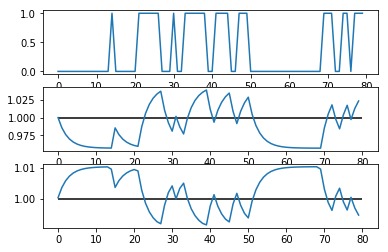

In [17]:
## plot optimal plans and check for convergence to steady state
fig, ax = plt.subplots(3,1)
ax[0].plot(range(T), zt[:-1])
ax[1].plot(range(T), kt[:-1])
ax[1].hlines(1, 0, T)
ax[2].plot(range(T), ht)
ax[2].hlines(1, 0, T)   

--------------------------------------------------------------------------------------------------------------------------------
<a id = "cont"></a>

### Continuous Random Variable

In "reality" (assuming we believe in the existence of technology shocks), $z_t$ can take more than two (or any discrete number of) values. In other words, $z_t$ should be modeled as a *continuous* random variable.

The usual assumption is that the log of the technology shock follows a first order autoregressive - AR(1) - process:

\begin{equation}
    \ln z_{t+1} = (1 - \rho) \ln \bar{z} + \rho \ln z_{t} + \epsilon_{t+1},\quad \epsilon_{t+1} \sim NID(0, \sigma^2)
\end{equation}

Hence, the source of the uncertainty is actually $\epsilon_{t+1}$ (which is not observed in period $t$). $\epsilon_t$ follows a a "white noise" process with zero mean and constant variance $\sigma^2$. Note that the expected value of $\ln z_t$ is

\begin{equation}
     \mu = (1 - \rho) \ln \bar{z}/ (1 - \rho) = \ln \bar{z}
\end{equation}    

The following function implements an AR(1) process; that is, it creates an array containing the evolution of $w_t = \ln z_t$ over time. 

In [18]:
## implement AR(1)

def ar1(T, rho, sigma, wbar = 0):
    w = np.zeros(T)
    ## initialize at wbar
    w[0] = wbar
    
    for t in range(1,T):        
        w[t] = (1 - rho) * wbar + rho * w[t-1] + sigma * np.random.normal()
        
    return w

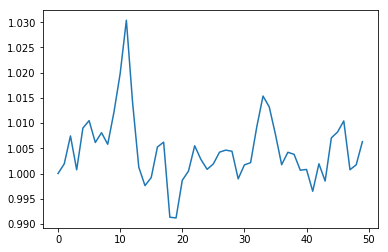

In [19]:
plt.plot(np.exp( ar1(50, 0.78, 0.0067) ) )

In the following, we use the same calibration - i.e., parameter values and functional forms - as above. The only information we need to add are values for the AR(1) parameter and the standard deviation of the white noise:

In [20]:
rho = 0.78
sigma = 0.0067

params['rho'] = rho
params['sigma'] = sigma

Before moving to solving the model, as a side note, there are essentially two steps in a "proper" RBC analysis that we omit here in the interest of time: 
- First, we have started with a stationary - or *detrended* - model (the same model that we have used throughout the course). A complete analysis would start with a more general, non-stationary model, and then transform it into a stationary one, along the lines of question 1 in the last problem set.

- Second, we have not really "calibrated" the model, but instead assumed (somewhat reasonable) parameter values and functional forms. A standard analysis would include a more careful calibration step. Compare DeJong and Dave (2011), chapter 11, for more information. With respect tp the functional forms, note that they should be chosen in a way that the long-term characteristics of economic growth outlined above are satisfied.

For solving the model using dynamic programming, note that we have two state variables, one endogenous ($k_t$) and one exogenous ($z_t$). Hence, we will have to deal with function approximation in two dimensions. 

For capital, we can define the Chebyshev nodes in the usual way.

In [21]:
m = 10
k_min = 0.7
k_max = 1.3

k_grid = fa.chebgrid(k_min, k_max, m)

In addition, we also need to define a Cheyshev grid for the productivity shock. Recall that we aim for end points that bracket all realizations of $z_t$. 

Since $z_t$ follows a random process, of course we cannot guarantee that it will never move outside the grid. That said, the following code provides a good "rule of thumb" for constructing the Chebyshev grid.  

In [22]:
epsmax = 4 * sigma
z_max = np.exp(epsmax/(1-rho))
z_min = 1/z_max

z_grid = fa.chebgrid(z_min, z_max, 10)
print(z_grid)

[0.88681282 0.89861957 0.92107735 0.95198783 0.98832529 1.02653274
 1.0628702  1.09378068 1.11623846 1.12804521]


We then use **meshgrid** to construct a grid in two dimensions. Next, we get an initial guess for the basis coefficients in the usual way.

In [23]:
Z_grid, K_grid = np.meshgrid(z_grid, k_grid)

In [24]:
## set the degree of approximation
n = m - 1
## initial guess for VF
V0 = (alpha / (1 - alpha * beta)) * np.log(K_grid )
## compute implied basis coefficients
a0 = fa.chebapprox_2d(V0, [n, n])

For using numerical integration below, we also need $N$ Gauss-Hermite quadrature nodes and weights:

In [25]:
N = 8
nodes, weights = np.polynomial.hermite.hermgauss(N)
print(nodes)

[-2.93063742 -1.98165676 -1.15719371 -0.38118699  0.38118699  1.15719371
  1.98165676  2.93063742]


Next, we define the objective for the optimization problem on the right hand side of the Bellman equation. The continuation value depends on next period's productivity shock, $z_{t + 1}$, which is unknown in the current period $t$.

Hence, we have the expected value over $V(k_{t+1}, z_{t +1})$:

\begin{equation}
    V(k_t, z_t) = \max{k_{t + 1}, h_t} u(c_t, h_t) + \beta \mathbb{E}_{z_{t + 1}} V(k_{t + 1}, z_{t + 1})
\end{equation}

We will use numerical integration to compute this expected value. First note that from the AR(1) process defined above, with $\bar{z} = 1$, we have

\begin{equation}
    \ln z_{t+1} = \rho \ln z_{t} + \epsilon_{t+1}\quad \Rightarrow\quad z_{t+1} = z_t^\rho \exp(\epsilon_{t+1})
\end{equation}

and hence 

\begin{equation}
    \mathbb{E}_{z_{t + 1}} V(k_{t + 1}, z_{t + 1}) = \mathbb{E}_{\epsilon_{t + 1}} V(k_{t + 1}, z_t^\rho \exp(\epsilon_{t+1}))
\end{equation}

Recall that both $k_{t+1}$ and $z_{t}$ are known in period $t$.

Recall from the last lecture that if $\epsilon_{t+1}$ is normally distributed with mean 0 and variance $\sigma^2$, the expectation of $g(\epsilon_{t+1})$ can be approximated by

\begin{equation}
    \mathbb{E}_{\epsilon_{t + 1}}[g(\epsilon_{t+1})] = \frac{1}{\sqrt{\pi}} \sum^n_{i = 1}  \omega_i g(\sqrt{2} \sigma \xi_i )
\end{equation}

where $\xi_i$ and $\omega_i$ are the quadrature nodes and weights, respectively.

Applied to the problem at hand, we can approximate the expected continuation value in the following way:

\begin{equation}
    \mathbb{E}_{\epsilon_{t + 1}} V(k_{t + 1}, z_t^\rho \exp(\epsilon_{t+1})) = \frac{1}{\sqrt{\pi}} \sum^n_{i = 1}  \omega_i V\left(k_{t+1}, z_t^\rho \exp( \sqrt{2} \sigma \xi_i) \right)
\end{equation}

How do we implement this? Note that we have to evaluate this sum in every optimization step, i.e. given a grid point $z_i$. 

Hence, in every optimization operation, we first evaluate $V\left(k_{t+1}, z_t^\rho \exp( \sqrt{2} \sigma \xi_i) \right)$ for a given quadrature node $\xi_i$, using our standard approximation with Chebyshev polynomials. As a second step, we sum up theses terms over all $N$ quadrature nodes.

In [26]:
def vf_rhs(x, k, z, coef, k_min, k_max, z_min, z_max, nodes, weights, pm):
    """
    RHS of the Bellman equation
    """
    kp = np.exp(x[0])   # a scalar!
    h = np.exp(x[1])    # a scalar!
    
    zp = z**pm['rho'] * np.exp(np.sqrt(2) * pm['sigma'] * nodes)  # an array
    
    cv = np.zeros(N)
    for ind in range(N):
        cv[ind] = np.polynomial.chebyshev.chebval2d(fa.chebconvert(kp, k_min, k_max),
                                                    fa.chebconvert(zp[ind], z_min, z_max), coef)
    
    return (- u(z * f(k, h, pm) + (1 - pm['delta']) * k - kp, h, pm) 
            - beta * (np.pi)**(-0.5) * weights @ cv) 

The remainder of the code follows the usual steps. We define our **opt_step** function (with the inner loop over both dimensions) and then solve the model using value function iteration.

In [27]:
def opt_step(k_grid, z_grid, x0, a_ch, k_min, k_max, z_min, z_max, nodes, weights, pm):     
    """
    Function that loops over all states (= elements in k_grid and q_grid) and solves the respective optimization problem (obj_fun, initial guess x0)
    for a given vector of Chebyshev basis coefficients a_ch
    -> uses Scipy's optimize module
    """
    ## initialize policy and value functions
    V = np.zeros((m, m))
    K = np.zeros((m, m))
    H = np.zeros((m, m))
    
    ## loop
    for (ind1, k) in enumerate(k_grid):
        for (ind2, z) in enumerate(z_grid):
        ## optimization step
            res = scipy.optimize.minimize(vf_rhs, x0, args = (k, z, a_ch, k_min, k_max, z_min, z_max, nodes, weights, pm), method ='BFGS') 
            V[ind1, ind2] = - res.fun
            K[ind1, ind2], H[ind1, ind2]  = np.exp( res.x )
            if res.success is not True:
                print(k, z, res.message)
        
    return V, K, H

In [28]:
## initialize initial guess for basis coefficients and optimization
a_ch = a0.copy()
x0 = np.log([1, 1])

eps = 1
it = 0
maxit = 300

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, K, H = opt_step(k_grid, z_grid, x0, a_ch, k_min, k_max, z_min, z_max, nodes, weights, params)
    ## fitting step
    a_new = fa.chebapprox_2d(V, [n, n])
    ## compute convergence criterion
    eps = np.linalg.norm(a_new - a_ch)
    ## update coefficients
    a_ch = a_new.copy()
    
    if it % 10 == 0:
        print(it, eps)

print(it, eps)

10 0.14867644441921413
20 0.015968342342394002
30 0.0017146637126655318
40 0.000184111310416797
50 1.9768807525197526e-05
60 2.122659501502375e-06
70 2.2791887399756352e-07
80 2.4472573312425472e-08
85 8.01918801873946e-09


In [34]:
## approximate the policy functions
a_k = fa.chebapprox_2d(K, [n, n])
a_h = fa.chebapprox_2d(H, [n, n])

In [30]:
## simulate the economy
T = 30
k0 = 1

np.random.seed(1)

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
ht = np.zeros(T)
yt = np.zeros(T)
invt = np.zeros(T)
ct = np.zeros(T)

## initial capital stock is given
kt[0] = k0

In [31]:
zt = np.exp( ar1(T+1, params['rho'], params['sigma']) )

## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(zt[t], z_min, z_max), a_k )
    ht[t] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(zt[t], z_min, z_max), a_h )
    
    yt[t] = zt[t] * f(kt[t], ht[t], params)
    invt[t] = kt[t + 1] - (1 - params['delta']) * kt[t]
    ct[t] = yt[t] - invt[t]

In [32]:
## for plotting: define steady states
ks, hs = 1, 1
ys = A
invs = params['delta'] 
cs = ys - invs

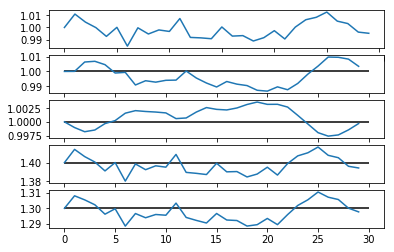

In [33]:
## plot optimal plans and check for convergence to steady state
fig, ax = plt.subplots(5,1)
ax[1].plot(range(T), kt[:-1])
ax[1].hlines(ks, 0, T)
ax[0].plot(range(T), zt[:-1])
ax[2].plot(range(T), ht)
ax[2].hlines(hs, 0, T) 
ax[3].plot(range(T), yt)
ax[3].hlines(ys, 0, T) 
ax[4].plot(range(T), ct)
ax[4].hlines(cs, 0, T) 

#### Computing Moments

Recall the question asked in the beginning: can the RBC model account for observed patterns of business-cycle activities? To answer this question, we simulate the model for a large number of periods and then compute the standard deviations for each variable (relative to their mean). 

In [35]:
T = 10000  ## total number of periods

np.random.seed(1)
zt = np.exp( ar1(T+1, params['rho'], params['sigma']) )

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
ht = np.zeros(T)
invt = np.zeros(T)
ct = np.zeros(T)
yt = np.zeros(T)

## initial capital stock is given
kt[0] = 1

In [44]:
zt = np.exp( ar1(T+1, params['rho'], params['sigma']) )

## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(zt[t], z_min, z_max), a_k )
    ht[t] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(zt[t], z_min, z_max), a_h )

    yt[t] = zt[t] * f(kt[t], ht[t], params)
    invt[t] = kt[t + 1] - (1 - params['delta']) * kt[t]
    ct[t] = yt[t] - invt[t]

moments = [np.std(np.log(yt) - np.log(ys)), \
           np.std(np.log(ct) - np.log(cs)), \
            np.std(np.log(invt) - np.log(invs)), \
            np.std(np.log(ht) - np.log(hs)), \
            np.std(np.log(kt) - np.log(ks))]

In [45]:
M = moments / moments[0]
for (ind, item) in enumerate(['output', 'consumption', 'investment', 'labor', 'capital']):
    print('Relative volatility of {}: {}'.format(item, M[ind]))

Relative volatility of output: 1.0
Relative volatility of consumption: 0.8431148371377803
Relative volatility of investment: 4.232068293850375
Relative volatility of labor: 0.37606779817640706
Relative volatility of capital: 1.372527633717757


How does the model compare with observed de-trended data? For the US in the period between 1950 and 2010, DeJong and Dave (2011) show that labor supply has been about as volatile as output, and hence much more volatile than the model predicts (0.37).

As a side note, our model overpredicts the relative volatility of consumption (0.84 rather than 0.44 in the data). However, this is due to the fact that we chose a additive-separable functional form for utility and did not worry much calibrating the model. With a different utility function and a more careful calibration,  DeJong and Dave (2011) get a relative volatility of 0.46 for consumption.

However, the lack of volatility in hours worked in the model is not remedied by a different utility function. In fact, this is a well-known shortcoming of the standard RBC model, and has prompted many extensions aiming to improve its performance in this direction.

In other words, the motivating question of Kydand and Prescott (1982) has to be answered in the following way: while the standard RBC model is able to capture *some* patterns of business-cycle activity, it fails to capture *all* of the patterns. 